Summary:
---
This notebook explains the analysis of a Heart Dataset, where we have about 303 subjects both Male and Female of varying ages. We look at 14 variables where they have different traits and a target variable that classifies if they have a high or low risk of heart disease. Then we are trying to analyze the data and see what significant factors are most important in flagging a person as a high risk patient for heart disease. In this document below i have explained my thinking process of how to start an analysis and try to dig out the reasons that classifies the subjects into two categories.

I have used R as my primary language. So, for data manipulation i ahve used both "data.table" and 'dplyr for data.frame" structure. SO, don't worry if you see different syntax for filtering and grouping data among different blocks.

Packages:
---

In [2]:
options(warn=-1)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
library(reshape)
library(reshape2)
library(viridis)
library(gridExtra)
library(hrbrthemes)
library(car)
library(lubridate)
library(RColorBrewer)
library(data.table)
"%notin%"=Negate("%in%")

In [150]:
path=getwd()
filepath=paste(path,'/Desktop/Heart Dataset/heart.xlsx',sep="/")

In [78]:
dataset=read_excel(filepath)
dataset[,c(2,3,6,7,9,11:14)]=sapply(dataset[,c(2,3,6,7,9,11:14)],as.factor)

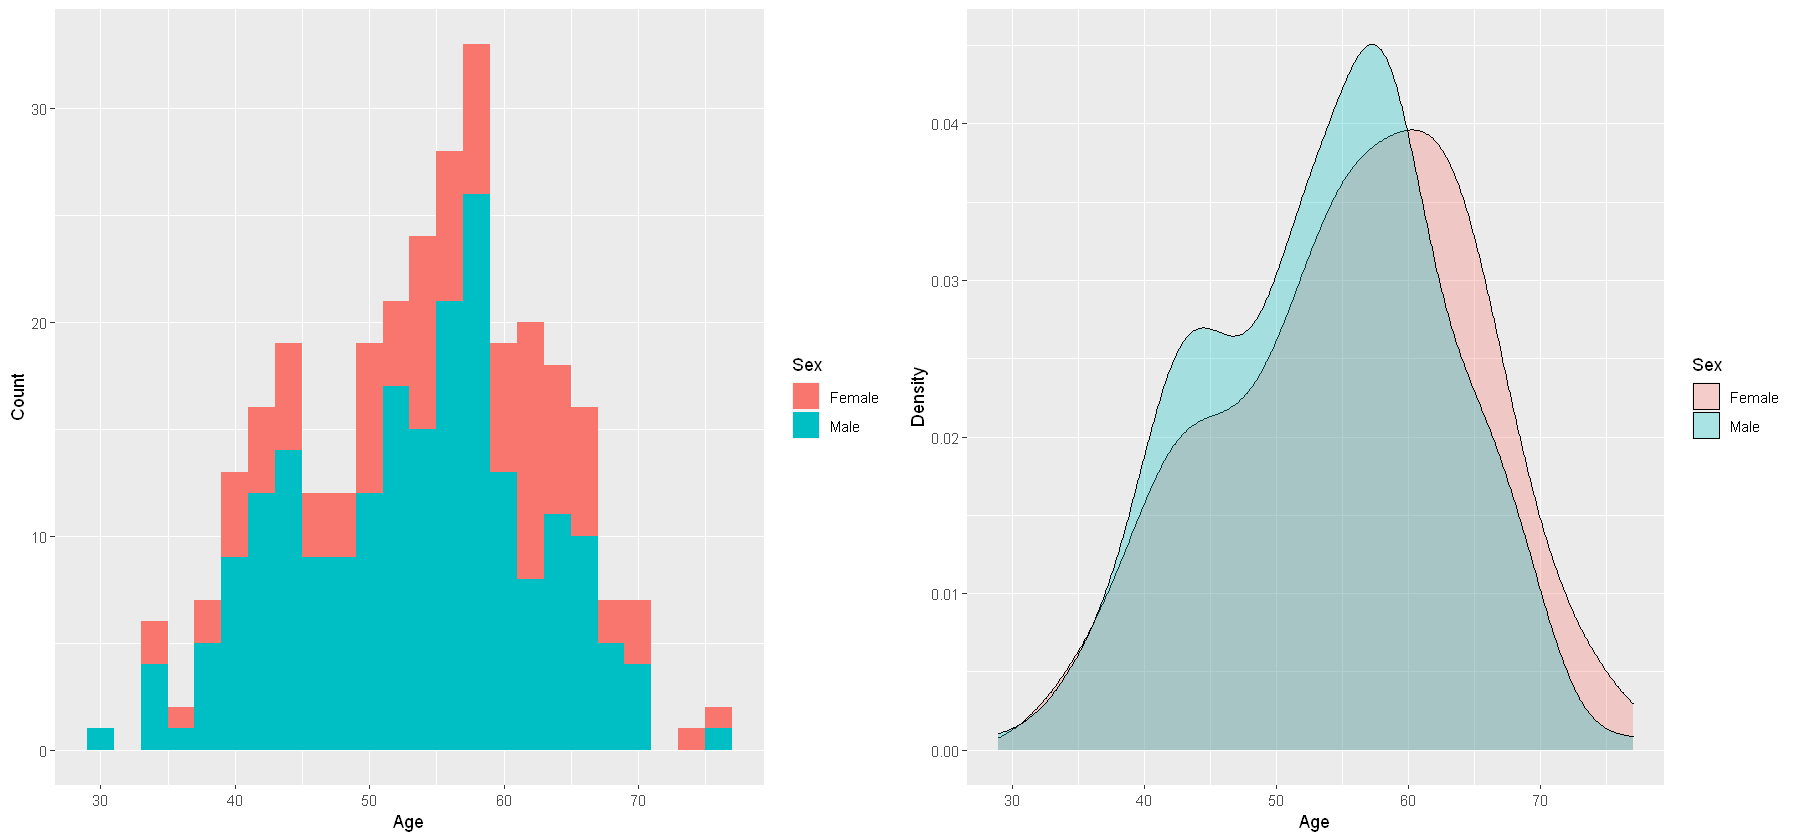

In [5]:
# Let's check the average age of the subjects in dataset:
options(repr.plot.width=15, repr.plot.height=7)
g1=ggplot(dataset,aes(x=age,fill=sex))+geom_histogram(binwidth=2)+
labs(x='Age',y='Count')+scale_fill_discrete(name='Sex',labels=c('Female','Male'))
g2=ggplot(dataset,aes(x=age,fill=sex))+geom_density(alpha=0.3)+
labs(x='Age',y='Density')+scale_fill_discrete(name='Sex',labels=c('Female','Male'))
grid.arrange(g1,g2,ncol=2)

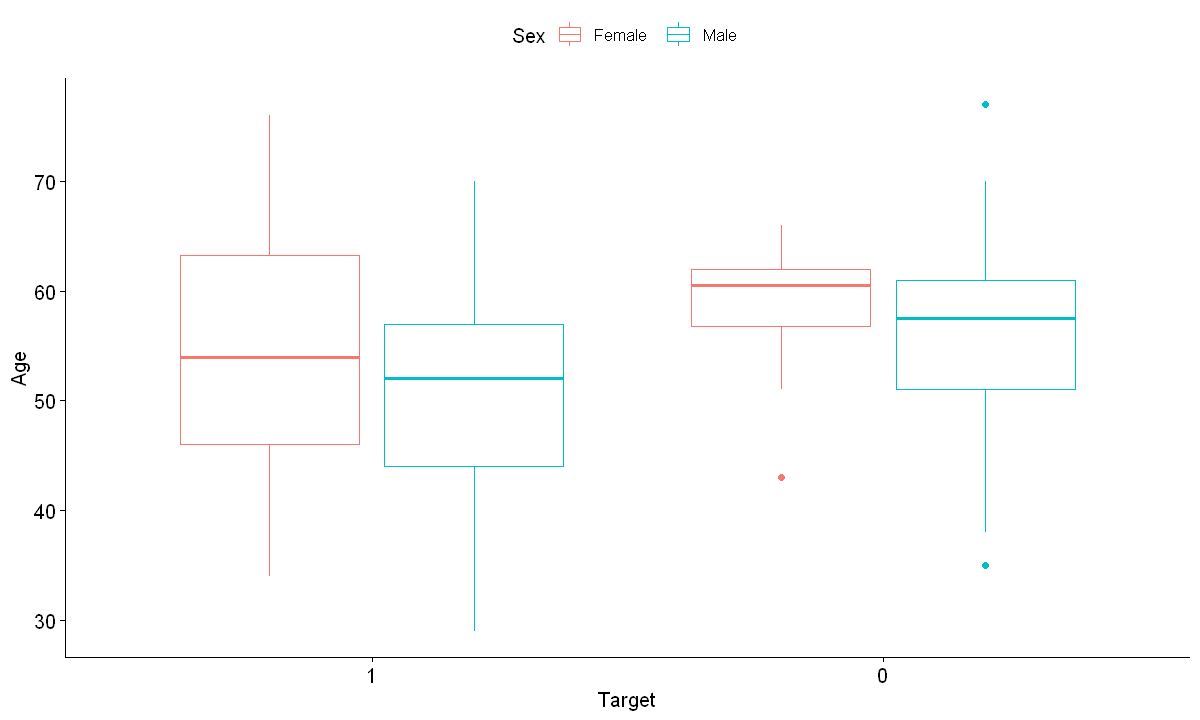

In [66]:
# Let's see the distribution of age w.r.t heart disease among different sexes:
options(repr.plot.width=10, repr.plot.height=6)
ggboxplot(dataset,x='target',y='age',color='sex')+labs(x='Target',y='Age')+
scale_color_discrete(name='Sex',labels=c('Female','Male'))

- One thing to mention here is that targets are reversed. "0" means the Patients at the high risk of heart disease. And "1" means patients at the low/no risk.

In [80]:
glimpse(dataset)

Rows: 303
Columns: 15
$ age      <dbl> 63, 37, 41, 56, 57, 57, 56, 44, 52, 57, 54, 48, 49, 64, 58...
$ sex      <chr> "1", "1", "0", "1", "0", "1", "0", "1", "1", "1", "1", "0"...
$ cp       <chr> "3", "2", "1", "1", "0", "0", "1", "1", "2", "2", "0", "2"...
$ trestbps <dbl> 145, 130, 130, 120, 120, 140, 140, 120, 172, 150, 140, 130...
$ chol     <dbl> 233, 250, 204, 236, 354, 192, 294, 263, 199, 168, 239, 275...
$ fbs      <chr> "1", "0", "0", "0", "0", "0", "0", "0", "1", "0", "0", "0"...
$ restecg  <chr> "0", "1", "0", "1", "1", "1", "0", "1", "1", "1", "1", "1"...
$ thalach  <dbl> 150, 187, 172, 178, 163, 148, 153, 173, 162, 174, 160, 139...
$ exang    <chr> "0", "0", "0", "0", "1", "0", "0", "0", "0", "0", "0", "0"...
$ oldpeak  <dbl> 2.3, 3.5, 1.4, 0.8, 0.6, 0.4, 1.3, 0.0, 0.5, 1.6, 1.2, 0.2...
$ slope    <chr> "0", "0", "2", "2", "2", "1", "1", "2", "2", "2", "2", "2"...
$ ca       <chr> "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0"...
$ thal     <chr> "1", "2", "2"

In [80]:
# Feature Engineering, created a categorical age feature that gives ranges of different ages.
dataset=dataset %>% mutate(age_cat=ifelse(age<=15,'0-15',ifelse(age<=35,'16-35',ifelse(age<=59,'36-59','>60'))))

In [81]:
dataset=dataset %>% mutate(sex=ifelse(sex=='0','Female','Male'))

dataset$age_cat=factor(dataset$age_cat,levels=c('16-35','36-59','>60'))

In [82]:
dataset=dataset %>% mutate(target=ifelse(target=='0','High_Risk','Low_Risk'))

In [83]:
sapply(dataset,class)

age         sex          cp    trestbps        chol         fbs 
  "numeric" "character" "character"   "numeric"   "numeric" "character" 
    restecg     thalach       exang     oldpeak       slope          ca 
"character"   "numeric" "character"   "numeric" "character" "character" 
       thal      target     age_cat 
"character" "character"    "factor"

Distribution of High Risk Patients w.r.t Sex:
---

In [9]:
dataset %>% group_by(sex,target) %>% summarize(n=n()) %>% mutate(freq=round(100*n/sum(n),2)) %>%
filter(target=='High_Risk') %>% select(sex,target,percent_high_risk=freq)

sex,target,percent_high_risk
<chr>,<chr>,<dbl>
Female,High_Risk,25.00
Male,High_Risk,55.07


The above analysis shows that out of all the Female subjects we have, only 25% of them have a high risk of Heart Disease, while out of all Male subjects, 55% of them have a high risk of heart disease.

Now, there maybe a possibility that all the male subjects we have in our dataset might fall in a high Age Category (like >60 yrs), maybe thats why there is a large percentage of Male subjects at a high risk of heart disease, or maybe this hypothesis of mine might be totally incorrect. So, to verify it let's look at the distribution of subjects of each sex among different age groups, just to see if my hypothesis is correct or not.

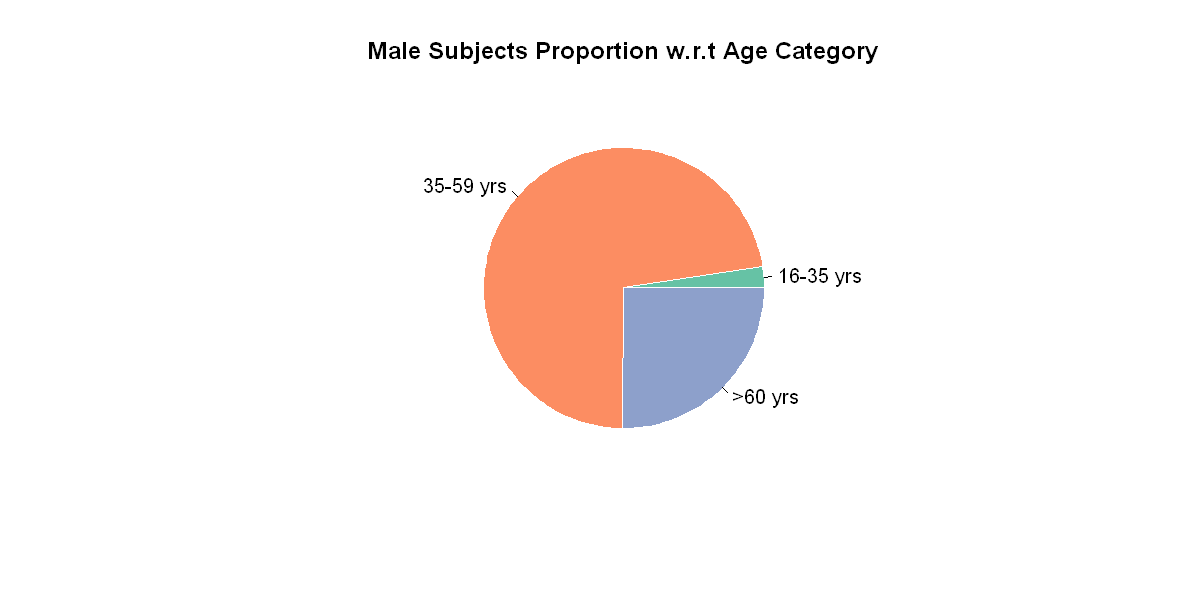

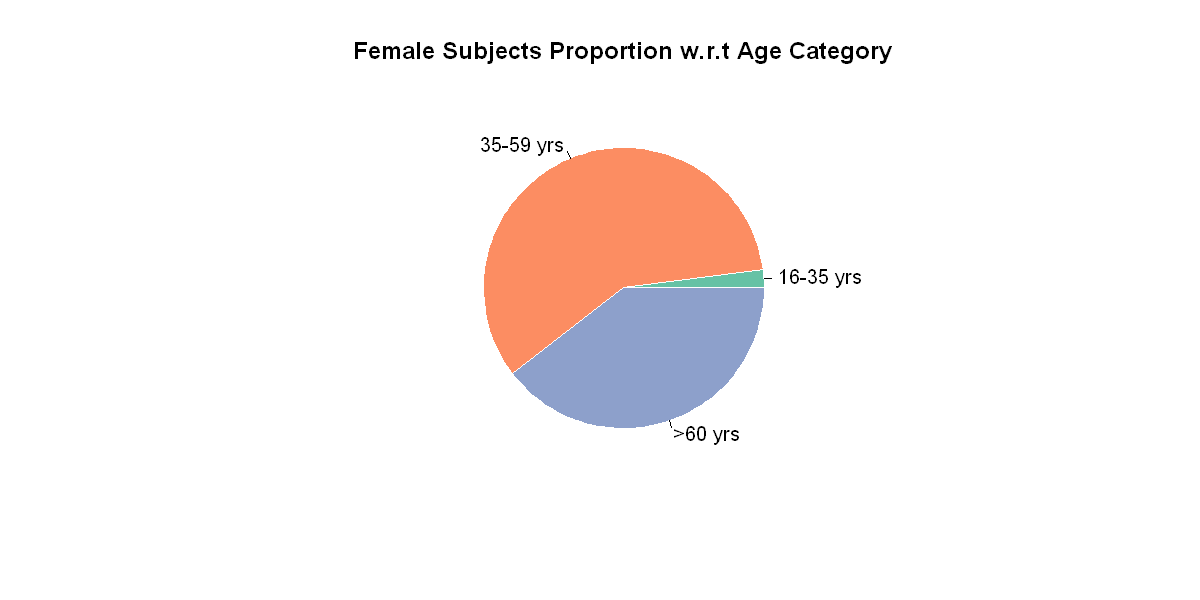

In [31]:
male_prop=dataset %>% filter(sex=='Male') %>% group_by(age_cat) %>% summarize(count=n())
female_prop=dataset %>% filter(sex=='Female') %>% group_by(age_cat) %>% summarize(count=n())

options(repr.plot.width=10, repr.plot.height=5)
color_scheme<- brewer.pal(2,"Set2")
c1=pie(male_prop$count,labels=c('16-35 yrs','35-59 yrs','>60 yrs'),border='white',col=color_scheme,
       main='Male Subjects Proportion w.r.t Age Category')
c2=pie(female_prop$count,labels=c('16-35 yrs','35-59 yrs','>60 yrs'),border='white',col=color_scheme,
      main='Female Subjects Proportion w.r.t Age Category')

So, the hypothesis is incorrect as Age is not just the only factor causing the high risk of heart disease, because the above Pie Chart tells us that 
that for female subjects we have more of them falling in >60 yr category
as compared to the proportion of males falling in the same category. So, if my hypothesis were true, then we might have seen that males would have a higher percentage of subjects falling in >60 yr old category.

Now, let's dive a bit deeper to see if we can look at other features that might help us with categorizing what really puts a person at the High Risk of Heart Disease.

Age wise distribution in "High Risk" category w.r.t Sex:
---
Here we want to see what percentage of people from a sex and belonging to a specific age group have high risk of heart disease.

Let's see what percentage of subjects from each sex are at high risk of heart disease for a specified age category.

In [27]:
summary_dataset=dataset %>% group_by(sex,age_cat) %>% summarize(total_count=n()) %>%
left_join(dataset %>% filter(target=='High_Risk') %>% group_by(sex,age_cat) %>% summarize(high_risk_patients=n()),
          by=c('sex','age_cat')) %>% replace_na(list(high_risk_patients=0)) %>%
mutate(percent_high_risk=round(100*high_risk_patients/total_count,2)) %>%
select(sex,age_cat,percent_high_risk) %>% arrange(age_cat,sex)

summary_dataset

sex,age_cat,percent_high_risk
<chr>,<fct>,<dbl>
Female,16-35,0.00
Male,16-35,40.00
Female,36-59,19.64
Male,36-59,48.67
Female,>60,34.21
Male,>60,75.00


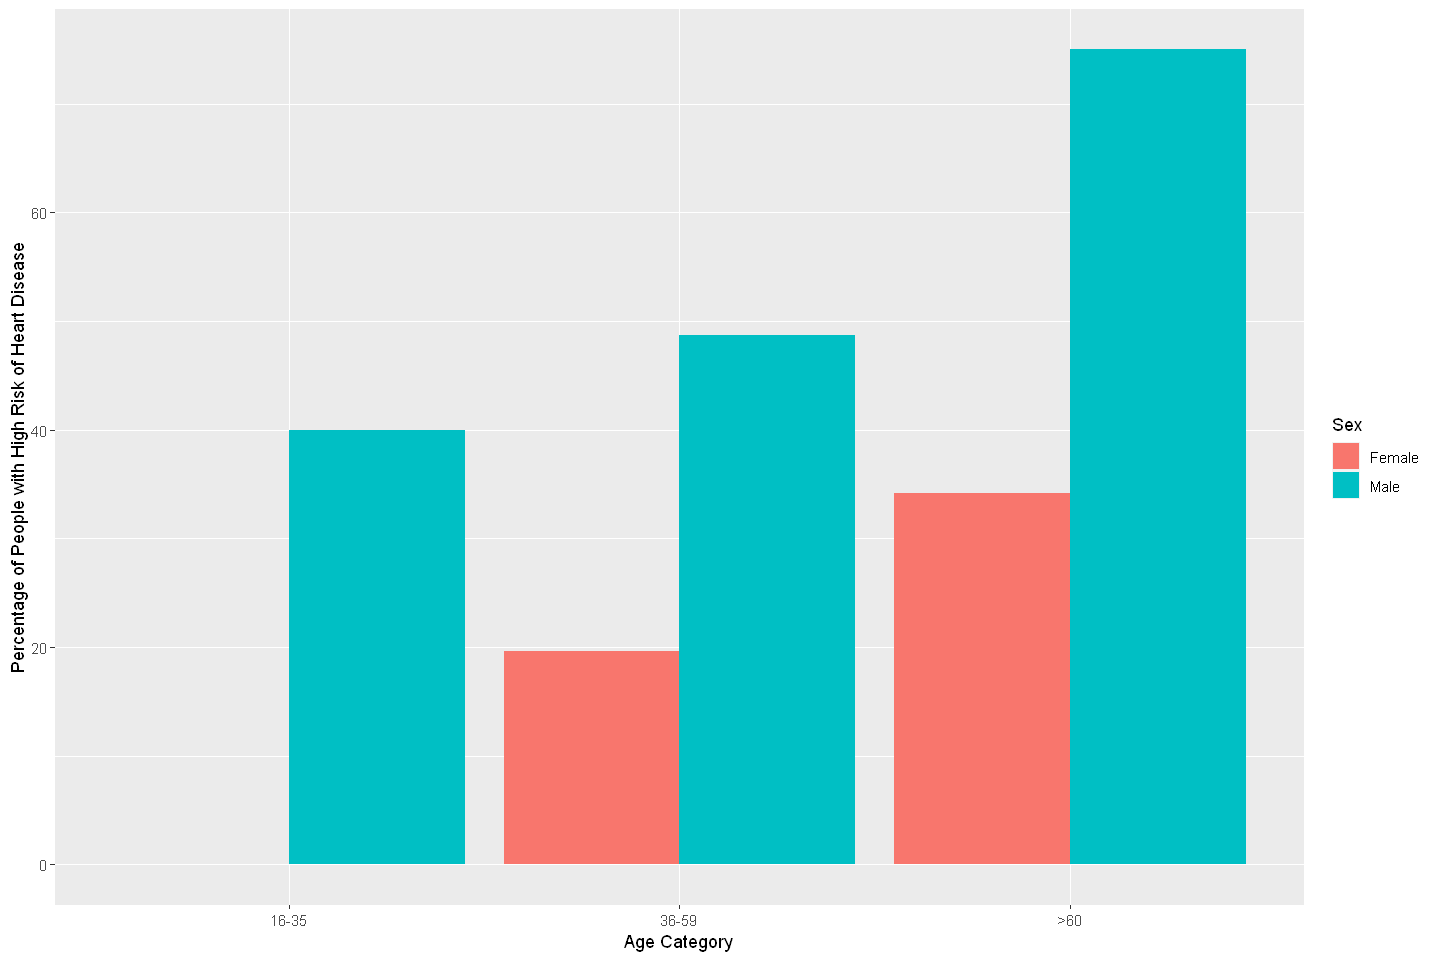

In [28]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(summary_dataset,aes(x=age_cat,y=percent_high_risk,fill=sex))+geom_col(stat='Identity',position=position_dodge())+
labs(x= 'Age Category',y='Percentage of People with High Risk of Heart Disease')+
scale_fill_discrete(name='Sex')

It seems like age is a significant factor in putting a person at the High Risk of Heart Disease. As, the graph above shows that for both "Sex" categories, as we go for the Higher Age Category, the Percentage of subjects at the High Risk of Heart Disease increase.

We can check it statistically by performing the Chi-Square Test of Independence.

In [37]:
print(table(dataset %>% select(sex,target)))

        target
sex      High_Risk Low_Risk
  Female        24       72
  Male         114       93


In [39]:
chisq.test(table(dataset %>% select(sex,target)))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(dataset %>% select(sex, target))
X-squared = 22.717, df = 1, p-value = 1.877e-06


Thus, the test proves that we reject the hypothesis that Sex and the Risk of Disease are Independent. Thus, we don't have enough evidence to say that they are Independent. What this essentially means is that being just a "Male" or a "Female" might somehow be a deciding factor in classifying the risk of heart disease. Now, with this test we can't just say this with conviction as we have to accept the alternative hypothesis that they are dependent. But what would be interesting to note is that how the rest of the features differ among "sex" so that being a "Male" or a "Female" is somehow classifies that you are at high risk or not.

Now let's check if the Age Category and the Risk of Disease are dependent or Independent.

In [40]:
table(dataset %>% select(age_cat,target))


       target
age_cat High_Risk Low_Risk
  16-35         2        5
  36-59        84      122
  >60          52       38

In [44]:
chisq.test(table(dataset %>% filter(sex=='Female') %>% select(age_cat,target)))



	Pearson's Chi-squared test

data:  table(dataset %>% filter(sex == "Female") %>% select(age_cat,     target))
X-squared = 3.2431, df = 2, p-value = 0.1976


In [45]:
chisq.test(table(dataset %>% filter(sex=='Male') %>% select(age_cat,target)))



	Pearson's Chi-squared test

data:  table(dataset %>% filter(sex == "Male") %>% select(age_cat, target))
X-squared = 11.292, df = 2, p-value = 0.003531


I ran the Chi-Square Test of Independence to see if there is any dependence between the Age and High Risk of Heart Disease. Before this we had seen that statistically "Sex" and the "Risk of Heart Disease" are dependent. Which means that being "Male" or "Female" effects the liklihood of the High Risk of Heart Disease somehow. So, for that reason i wanted to test the Independence of Age and High Risk of Heart Disease separately for "Male" and "Female" subjects.

- The Analysis shows that that for Males, the High Risk of Heart Disease is dependent on the Age Category, and as your age increases or you get older, the Risk of Heart Disease increases.
- On the contrary, for Females, we fail to reject the hypothesis that Age and Risk of Heart Disease are Independent.

Important Point:
---
Now, we need to further figure out why the age effects the likelihood of heart disease in males and to figure that out, I would look up the other traits like Blood Pressure, Cholestrol Level, Heart Rate etc, and see how they change with age among males.

As, for females subjects as we are currently not sure if the age and liklihood of heart disease are independent or dependent, thus, i would perform a similar kind of analysis on the data for females subjects aswell to see if we can find a pattern.

Type of Chest Pain:
---

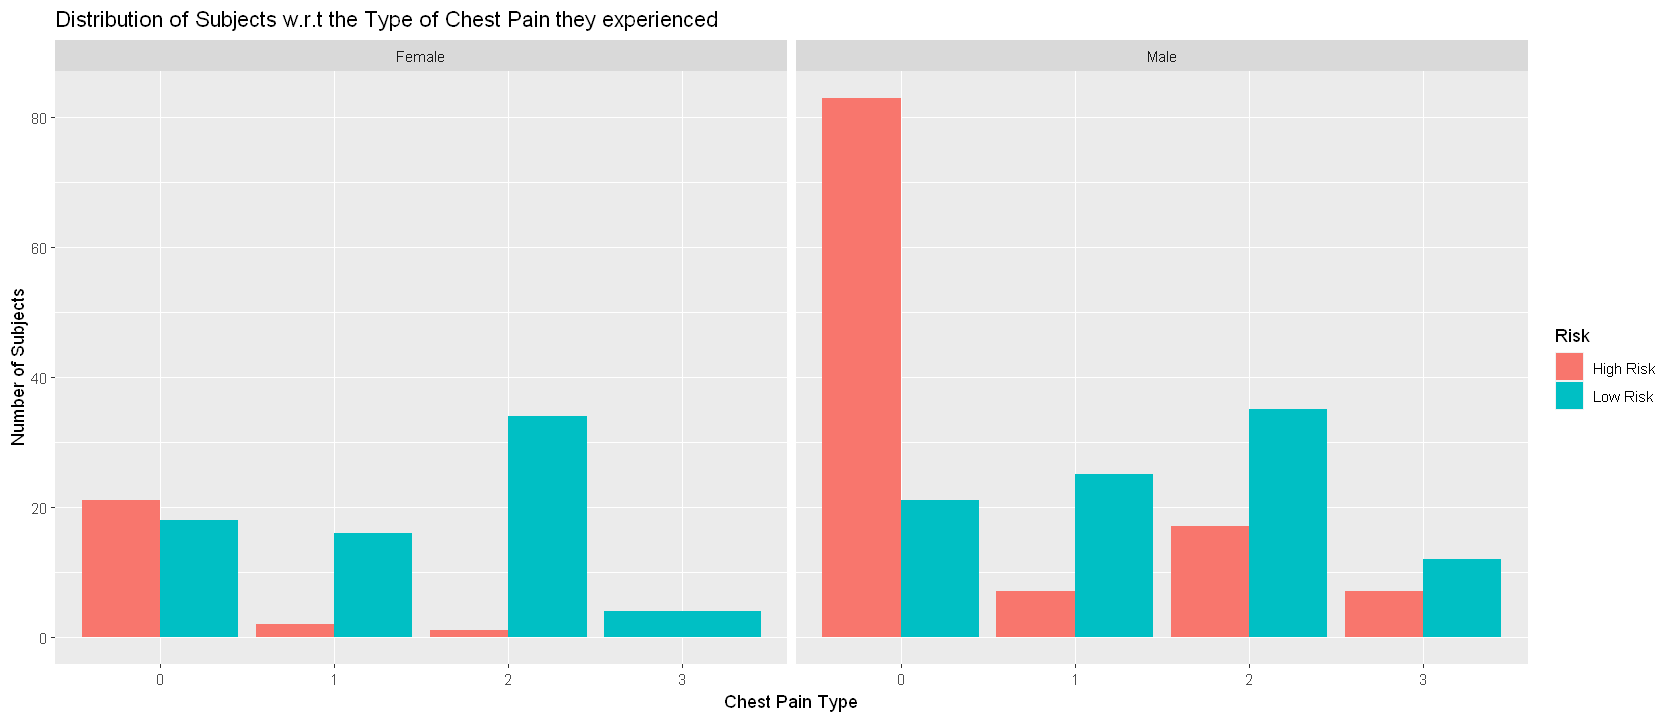

In [71]:
x1=dataset %>% group_by(sex,target,cp) %>% summarize(n=n())

options(repr.plot.width=14, repr.plot.height=6)

ggplot(x1,aes(x=cp,y=n,fill=target))+geom_col(stat='Identity',position=position_dodge())+facet_wrap(~sex)+
labs(title='Distribution of Subjects w.r.t the Type of Chest Pain they experienced',y='Number of Subjects',
    x='Chest Pain Type')+scale_fill_discrete(name='Risk',labels=c('High Risk','Low Risk'))

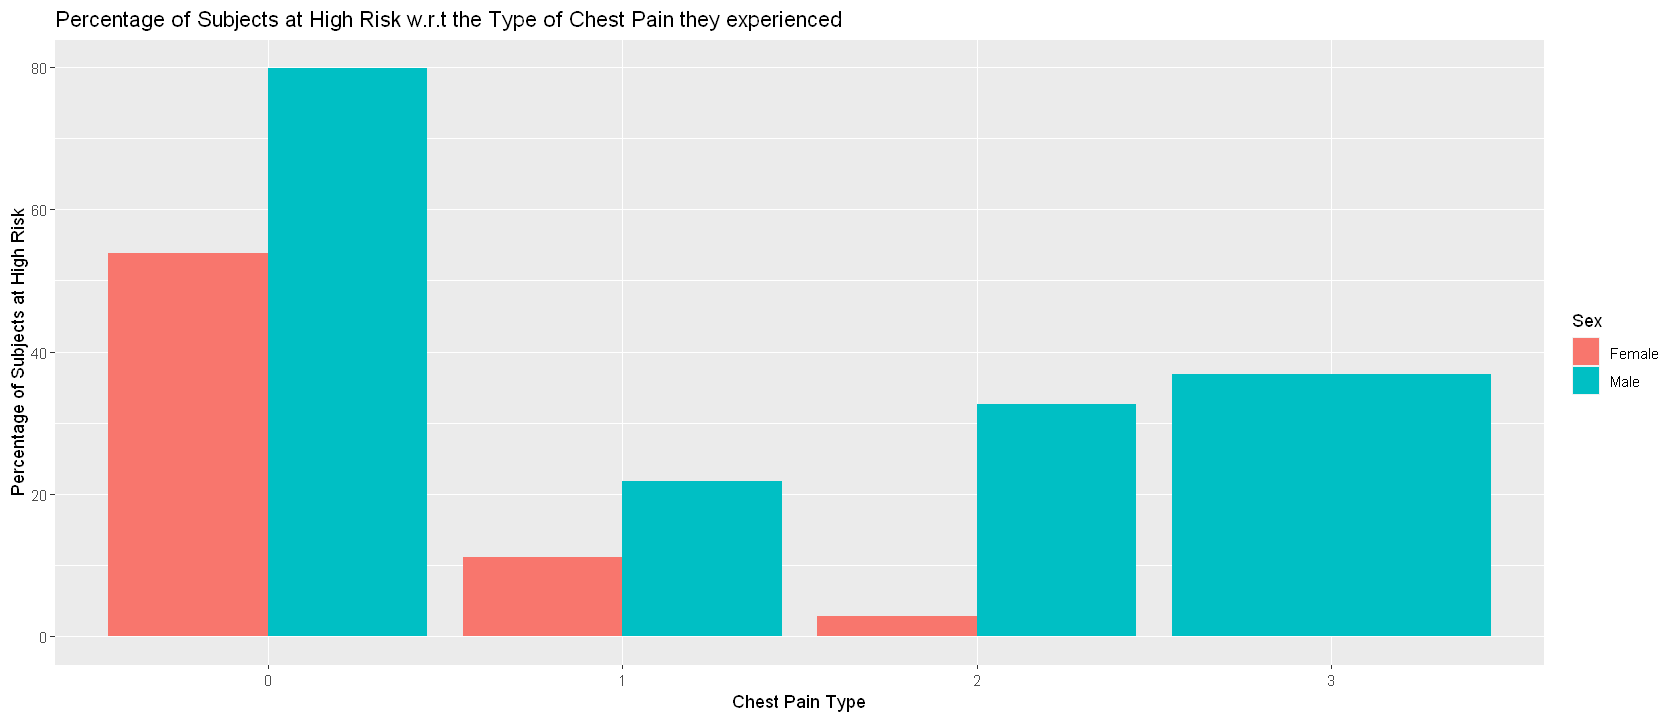

In [106]:
summary_dat=dataset %>% group_by(sex,cp,target) %>% summarize(n=n()) %>% mutate(freq=round(100*n/sum(n),1)) %>%
filter(target=='High_Risk')

options(repr.plot.width=14, repr.plot.height=6)
ggplot(summary_dat,aes(x=cp,y=freq,fill=sex))+geom_col(stat='Identity',position=position_dodge())+
labs(title='Percentage of Subjects at High Risk w.r.t the Type of Chest Pain they experienced',
     y='Percentage of Subjects at High Risk',
    x='Chest Pain Type')+scale_fill_discrete(name='Sex')

Seems like the Chest Pain type Zero is the one related to High Risk of Heart Disease, as the most number of patients that are at High Risk of Heart Disease experience the Chest Pain Type Zero. There are two other things to be noticed here:
- Percentage of Male Subjects at High Risk of Heart Disease in Each Chest Pain Category is higher than that of Female High Risk Subjects.
- Secondly, an important thing to note is that Patients feeling Chest Pain Type zero are most likely at the Risk of Heart Disease as almost 59% of Female Subjects experiencing chest pain type zero are at the high risk of Heart Disease, whereas about 80% of Male subjects experiencing Chest Pain type zero are at the High risk of heart disease. 

Thus, it means Chest Pain is a distinctive characteristic to classify the patients at High Risk of Heart Disease especially Males.

First, i am going to change the column names just to make them a bit more intuitive.

In [84]:
colnames(dataset)[c(3:13)]<- c('chestpain_type','rest_bp','cholestrol','fasting_bs','rest_ecg','max_heart_rate',
                              'exer_angina','oldpeak','slope','numvessels_color','defect_type')

In [85]:
dat=as.data.table(dataset)


Defect Type:
---

In [50]:
dat[,.N,by=.(defect_type,target)][order(defect_type,target)]

defect_type,target,N
<chr>,<chr>,<int>
0,High_Risk,1
0,Low_Risk,1
1,High_Risk,12
1,Low_Risk,6
2,High_Risk,36
2,Low_Risk,130
3,High_Risk,89
3,Low_Risk,28


In [47]:
dat[defect_type==3,.N,by=.(defect_type,sex)][order(defect_type,sex)]

defect_type,sex,N
<chr>,<chr>,<int>
3,Female,15
3,Male,102


Seems like the Defect Type 3 has the highest number of "High Risk" patients. And the second summary table confirms that males take up a large percentage of patients falling in the category that has the defect type 3. Another point that is in favour of males having a high liklihood of "High Risk" of heart disease.

In [70]:
dat[target=='High_Risk',.N,by=.(defect_type,sex)][order(defect_type,sex)]

defect_type,sex,N
<chr>,<chr>,<int>
0,Male,1
1,Female,1
1,Male,11
2,Female,10
2,Male,26
3,Female,13
3,Male,76


In [68]:
dat[,{
    total_num = .N
    .SD[,.(percentage_highrisk=round(.N/total_num,2)),by=target]
},by=numvessels_color][target=='High_Risk'][order(numvessels_color)]

numvessels_color,target,percentage_highrisk
<chr>,<chr>,<dbl>
0,High_Risk,0.26
1,High_Risk,0.68
2,High_Risk,0.82
3,High_Risk,0.85
4,High_Risk,0.20


In [72]:
names(dat)

[1] "age"              "sex"              "chestpain_type"   "rest_bp"         
 [5] "cholestrol"       "fasting_bs"       "rest_ecg"         "max_heart_rate"  
 [9] "exer_angina"      "oldpeak"          "slope"            "numvessels_color"
[13] "defect_type"      "target"           "age_cat"

In [82]:
# Fasting Blood Sugar Analysis:
dat[,.N,by=.(fasting_bs,target)][order(fasting_bs)]

fasting_bs,target,N
<chr>,<chr>,<int>
0,Low_Risk,142
0,High_Risk,116
1,Low_Risk,23
1,High_Risk,22


In [76]:
# Further Analysis of Fasting Blood Sugar at "Sex" level:
dat[,.N,by=.(fasting_bs,sex)][order(fasting_bs)]

fasting_bs,sex,N
<chr>,<chr>,<int>
0,Male,174
0,Female,84
1,Male,33
1,Female,12


In [81]:
# Rest ECG:
dat[,.N,by=.(rest_ecg,target)][order(rest_ecg)]

rest_ecg,target,N
<chr>,<chr>,<int>
0,Low_Risk,68
0,High_Risk,79
1,Low_Risk,96
1,High_Risk,56
2,Low_Risk,1
2,High_Risk,3


In [83]:
# Exer Angina:
dat[,.N,by=.(exer_angina,target)][order(exer_angina)]

exer_angina,target,N
<chr>,<chr>,<int>
0,Low_Risk,142
0,High_Risk,62
1,Low_Risk,23
1,High_Risk,76


In [88]:
# further Analysis of Exercise Angina at "Sex" level:
dat[,.N,by=.(exer_angina,sex)][order(exer_angina)]

dat[,{total=.N
     .SD[, .(percentage=round(.N/total,2)),by=exer_angina]},by=sex][exer_angina==0]

exer_angina,sex,N
<chr>,<chr>,<int>
0,Male,130
0,Female,74
1,Female,22
1,Male,77


sex,exer_angina,percentage
<chr>,<chr>,<dbl>
Male,0,0.63
Female,0,0.77


In [85]:
dat[,.N,by=sex]

sex,N
<chr>,<int>
Male,207
Female,96


Blood Pressure, Cholestrol Level, Max Heart Rate and Old Peak:
---
There is some categories that can be discovered further from the findings above after we did separate analysis on different features to understand their effect. We'll dig into that but first let me just plot a statistic showing the values (more like distribution) of these four numeric indicators amongst the target (i.e High Risk and Low Risk Patients).

In [147]:
dat[,lapply(.SD,mean),by=.(target),.SDcols=c('rest_bp','cholestrol','max_heart_rate','oldpeak')]

target,rest_bp,cholestrol,max_heart_rate,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Low_Risk,129.3030,242.2303,158.4667,0.5830303
High_Risk,134.3986,251.0870,139.1014,1.5855072


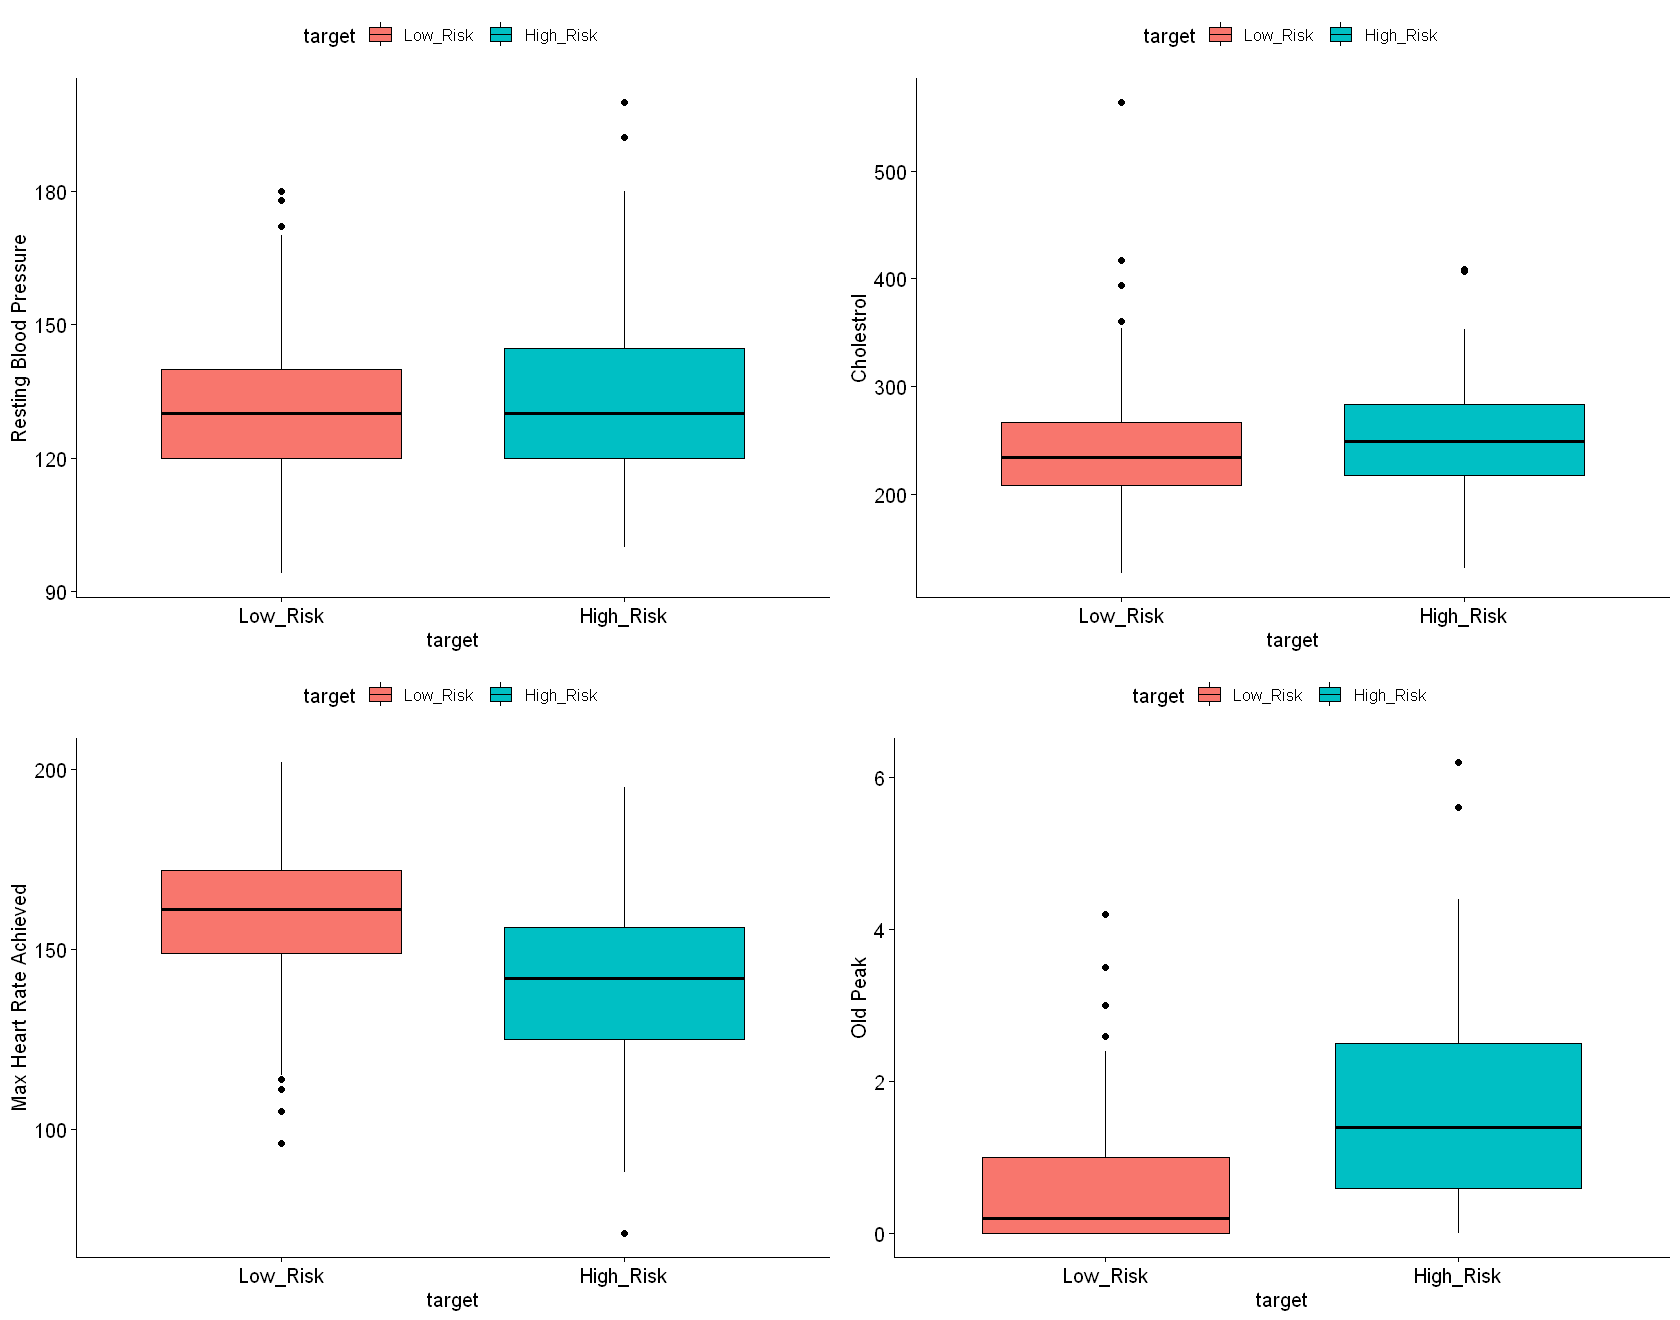

In [148]:
options(repr.plot.width=14, repr.plot.height=11)

s1=ggboxplot(dataset,fill='target',x='target',y='rest_bp')+labs(x='target',y='Resting Blood Pressure')
s2=ggboxplot(dataset,fill='target',x='target',y='cholestrol')+labs(x='target',y='Cholestrol')
s3=ggboxplot(dataset,fill='target',x='target',y='max_heart_rate')+labs(x='target',y='Max Heart Rate Achieved')
s4=ggboxplot(dataset,fill='target',x='target',y='oldpeak')+labs(x='target',y='Old Peak')

grid.arrange(s1,s2,s3,s4,ncol=2)

General Traits that distinguishes High Risk Patients from Low Risk ones are that they have:
1. High Resting Blood Pressure
2. High Cholestrol levels
3. Low Max Heart Rate Achieved
4. High Old Peak

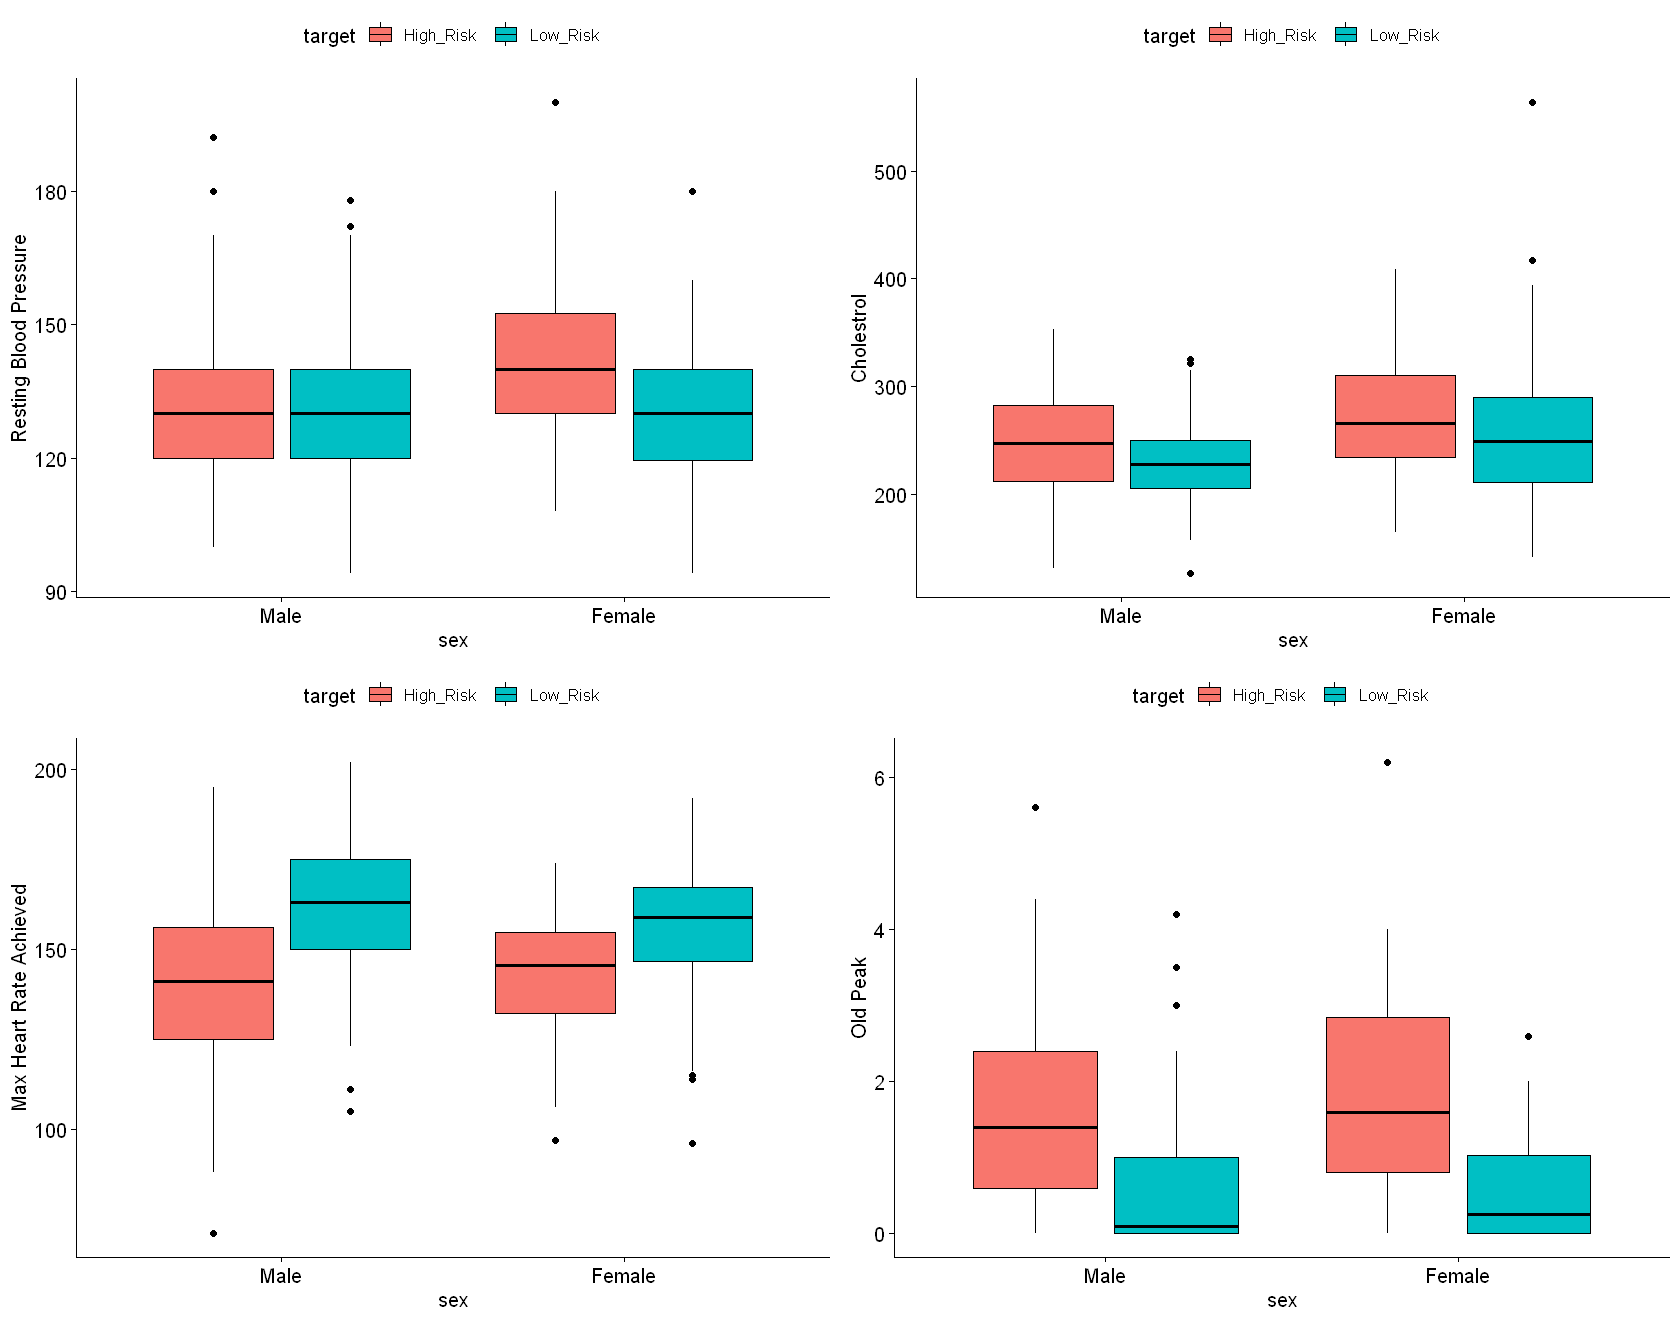

In [146]:
# Distribution w.r.t Sex:
options(repr.plot.width=14, repr.plot.height=11)

s1=ggboxplot(dataset,fill='target',x='sex',y='rest_bp')+labs(x='sex',y='Resting Blood Pressure')
s2=ggboxplot(dataset,fill='target',x='sex',y='cholestrol')+labs(x='sex',y='Cholestrol')
s3=ggboxplot(dataset,fill='target',x='sex',y='max_heart_rate')+labs(x='sex',y='Max Heart Rate Achieved')
s4=ggboxplot(dataset,fill='target',x='sex',y='oldpeak')+labs(x='sex',y='Old Peak')

grid.arrange(s1,s2,s3,s4,ncol=2)

Going Deeper and making Categorization:
---
Let's dig a bit deeper and see how average levels of Blood Pressure, Cholestrol Levels, Max Heart Rate Achieved and Old Peak are distributed for Patients falling in these categories as these categories are the ones that show the patient falling in these categories are the most at the risk of Heart Disease.

- Chest Pain Type 0
- Defect Type 3
- Num Color Vessels 1,2 and 3
- Exercise Angina 0

Let's divide our observations into different categories of High Risk Patients to further dive into how distinguishable Patients are in the High Risk Category from each other.

- High_Risk_Level_4 -> Patients that falls in the category fulfilling all the above criterias
- High_Risk_Level_3 -> Patients that falls in the category fulfilling exactly 3(any) of the above criterias
- High_Risk_Level_2 -> Patients that falls in the category fulfilling exactly 2(any) of the above criterias
- High_Risk_Level_1 -> Patients that falls in the category fulfilling exactly 1(any) of the above criterias
- Low Risk -> Patients that does'nt fall into any of the above categories.

For Numcolor_Vessels, let's put 1,2 and 3 into one category of 1 and keep zero as zero, just for binary identification and easy matching.

In [86]:
dat<- dat %>% mutate(numvessels_color=ifelse(numvessels_color %in% c('1','2','3'),'1','0'))
dat=as.data.table(dat)

In [89]:
test=c()
test$chestpain_type='0'
test$defect_type='3'
test$numvessels_color='1'
test$exer_angina='0'

matches=c()
for(i in 1:dim(dat)[1]){
    l=c(dat[,.(chestpain_type,defect_type,numvessels_color,exer_angina)][i])
    matches=c(matches,length(intersect(l,test)))
}
dat$matches=matches

In [94]:
dat=dat %>% mutate(risk_cat=ifelse(matches==4,'High_Risk_Level_4',ifelse(matches==3,'High_Risk_Level_3',ifelse(matches==2,
                                                                                                 'High_Risk_Level_2',
                                                                                                 ifelse(matches==1,'High_Risk_Level_1','Low_Risk')))))

In [95]:
dat %>% group_by(risk_cat) %>% summarize(count=n())

risk_cat,count
<chr>,<int>
High_Risk_Level_1,71
High_Risk_Level_2,130
High_Risk_Level_3,102


In [98]:
dat[,lapply(.SD,mean),by=.(risk_cat,sex),.SDcols=c('rest_bp','cholestrol','max_heart_rate','oldpeak')][order(risk_cat,sex)]

risk_cat,sex,rest_bp,cholestrol,max_heart_rate,oldpeak
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
High_Risk_Level_1,Female,125.1389,244.4167,151.1667,0.4611111
High_Risk_Level_1,Male,131.9429,233.4286,161.3429,0.7285714
High_Risk_Level_2,Female,134.8696,269.6957,154.8478,0.7913043
High_Risk_Level_2,Male,129.8452,237.6667,150.1310,0.9011905
High_Risk_Level_3,Female,147.6429,277.1429,138.7857,2.2214286
High_Risk_Level_3,Male,131.6023,243.1705,142.9205,1.4738636


In [105]:
dat$risk_cat=factor(dat$risk,levels=c('High_Risk_Level_1','High_Risk_Level_2','High_Risk_Level_3'))

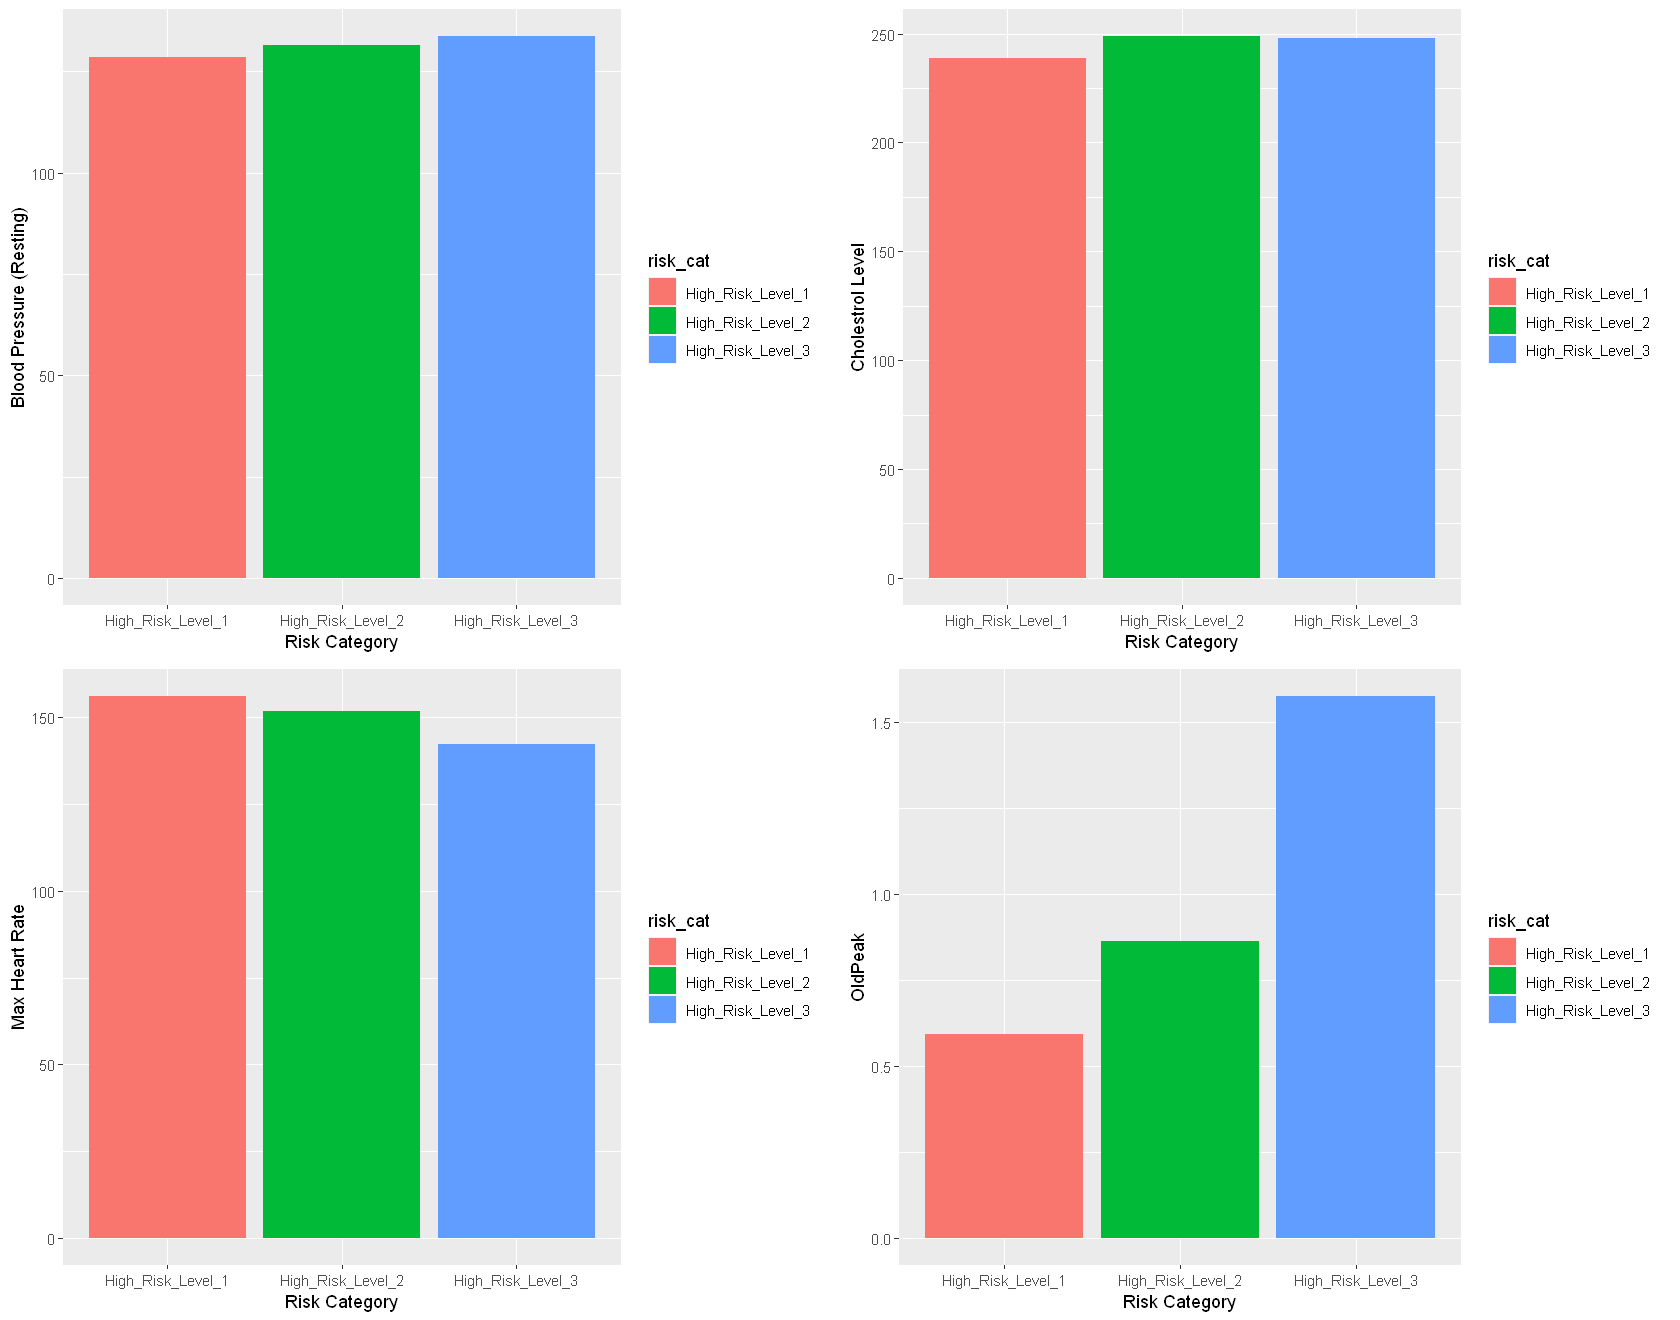

In [113]:
summary=dat[,lapply(.SD,mean),by=.(risk_cat),.SDcols=c('rest_bp','cholestrol','max_heart_rate','oldpeak')][order(risk_cat)]

g1=ggplot(summary)+geom_col(aes(x=risk_cat,y=rest_bp, fill=risk_cat))+labs(x='Risk Category',y='Blood Pressure (Resting)')
g2=ggplot(summary)+geom_col(aes(x=risk_cat,y=cholestrol, fill=risk_cat))+
labs(x='Risk Category',y='Cholestrol Level')
g3=ggplot(summary)+geom_col(aes(x=risk_cat,y=max_heart_rate, fill=risk_cat))+
labs(x='Risk Category',y='Max Heart Rate')
g4=ggplot(summary)+geom_col(aes(x=risk_cat,y=oldpeak, fill=risk_cat))+
labs(x='Risk Category',y='OldPeak')

grid.arrange(g1,g2,g3,g4,ncol=2)

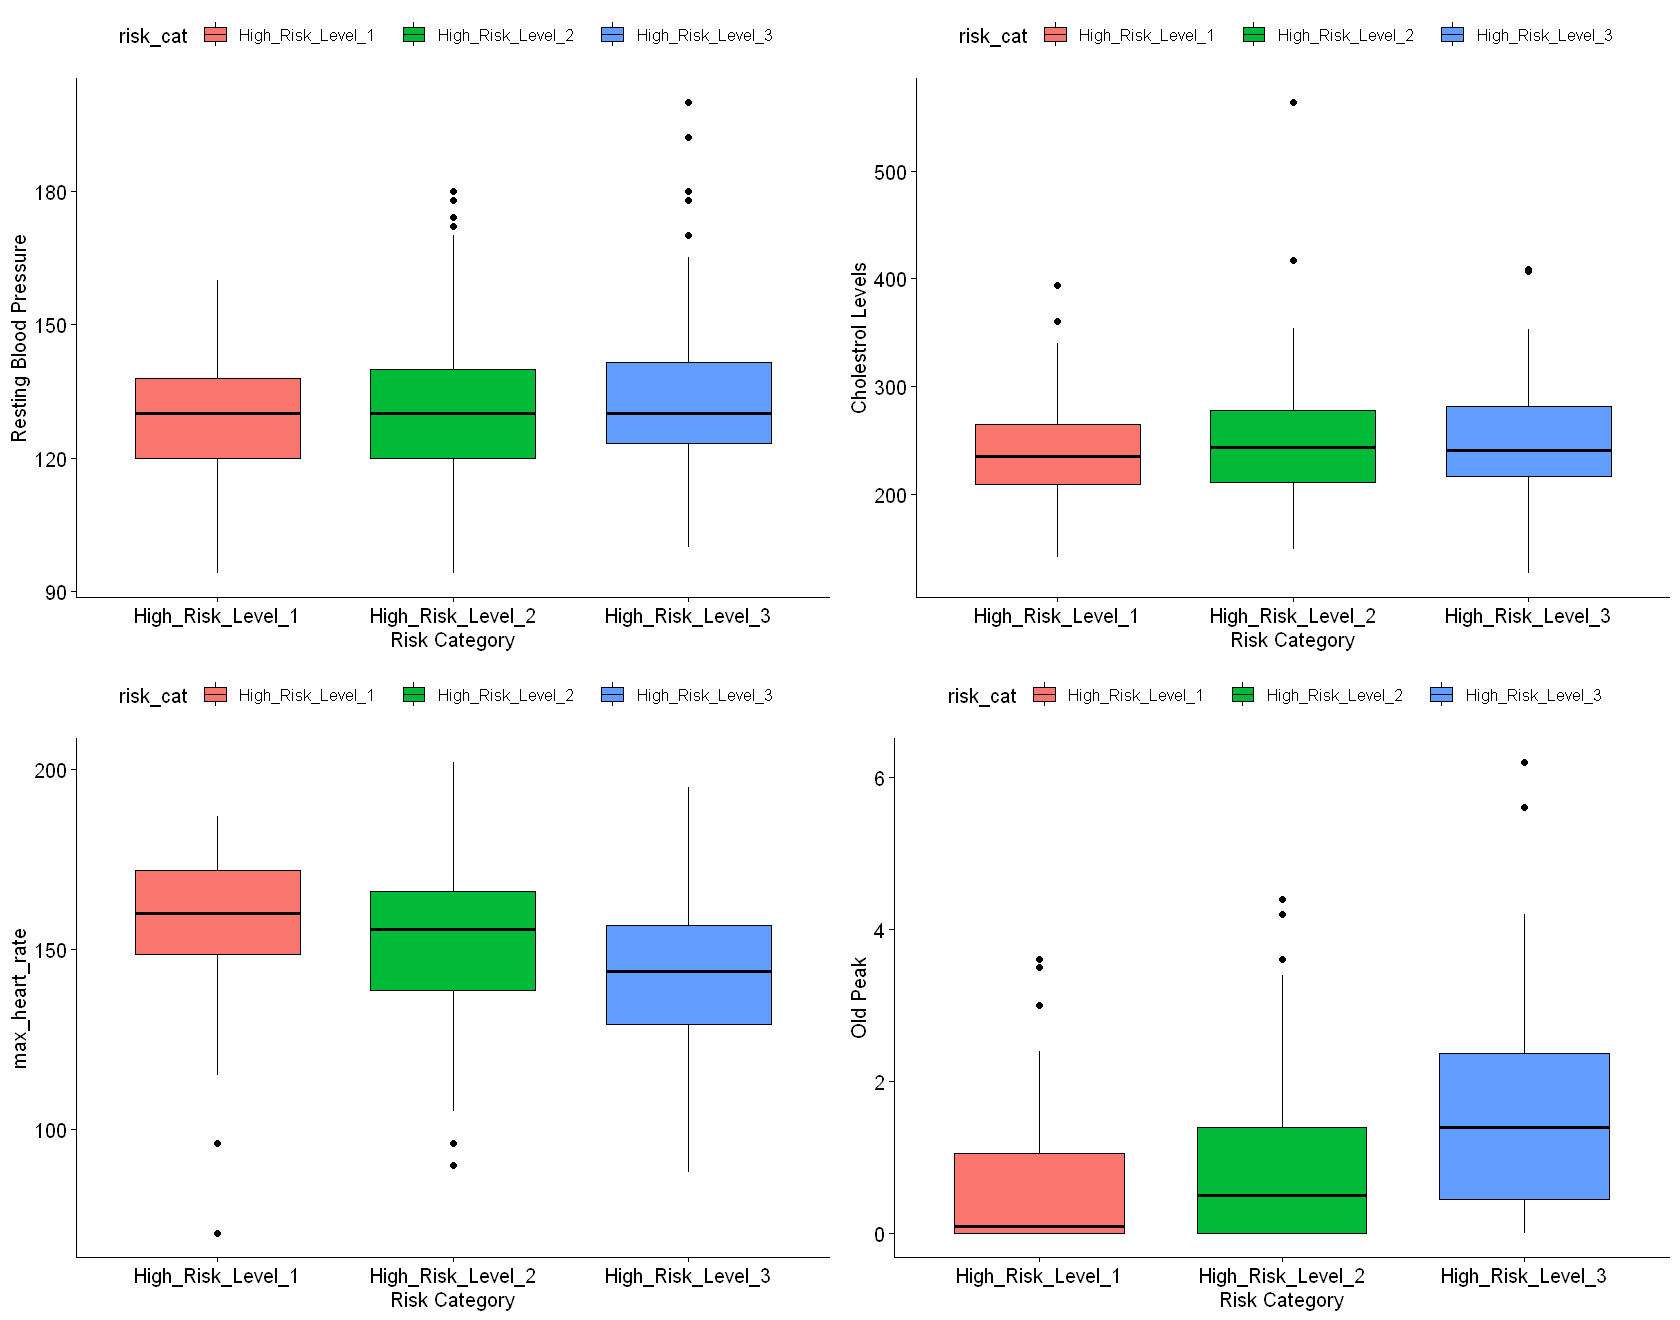

In [149]:
g1=ggboxplot(dat,x='risk_cat',y='rest_bp',fill='risk_cat')+labs(x='Risk Category',y='Resting Blood Pressure')
g2=ggboxplot(dat,x='risk_cat',y='cholestrol',fill='risk_cat')+labs(x='Risk Category',y='Cholestrol Levels')
g3=ggboxplot(dat,x='risk_cat',y='max_heart_rate',fill='risk_cat')+labs(x='Risk Category',y='max_heart_rate')
g4=ggboxplot(dat,x='risk_cat',y='oldpeak',fill='risk_cat')+labs(x='Risk Category',y='Old Peak')


grid.arrange(g1,g2,g3,g4,ncol=2)

So, the above two graphs show that the traits of Blood Pressure, Max Heart Rate Achieved, Old Peak and Cholestrol levels discovered for the Target (i.e High Risk vs. Low Risk) are in accordance with what we found here for the categories i built manually by categorizing certain variables on certain values and creating different levels of High Risk Categories.

Let's look at the percentage of High Risk Patients out of the patients falling in different Risk categories i made.

In [125]:
dat[,{total=.N
     .SD[,.(percentage=round(.N/total,2)),by=.(target)]},by=risk_cat][order(risk_cat)][target=='High_Risk']

risk_cat,target,percentage
<fct>,<chr>,<dbl>
High_Risk_Level_1,High_Risk,0.11
High_Risk_Level_2,High_Risk,0.37
High_Risk_Level_3,High_Risk,0.80


Findings:
---
The categories i had made above shows a clear trend. High Risk Category 3 has the highest percentage of high risk patients from the patietns falling in this category. So, just to explain it, as this is 80%, this means that out of all the patients satifying the criteria for falling into this High Risk 3 category, 80% of them are actually at High Risk.
So, this seems like a strong predictor in distinguishing or classifying the risk of heart disease in patients.

Next up to close on our analysis, we can look into how the Blood Pressure, Heart rate, Cholestrol Levels etc vary amongst these categories and we can also segregate them on the basis of Sex.

In [127]:
dat[,{total=.N
     .SD[,.(percentage=round(.N/total,2)),by=.(target)]},by=.(risk_cat,sex)][order(risk_cat,sex)][target=='High_Risk']

risk_cat,sex,target,percentage
<fct>,<chr>,<chr>,<dbl>
High_Risk_Level_1,Female,High_Risk,0.03
High_Risk_Level_1,Male,High_Risk,0.20
High_Risk_Level_2,Female,High_Risk,0.22
High_Risk_Level_2,Male,High_Risk,0.45
High_Risk_Level_3,Female,High_Risk,0.93
High_Risk_Level_3,Male,High_Risk,0.78


Seems like men have are usually at high risk of heart disease as compared to women. Because even if we look at High Risk Level category, which from above is made up on the criteria that if any patient has exactly one (any) of these things:

    Chest Pain Type 0
    Defect Type 3
    Num Color Vessels 1,2 and 3
    Exercise Angina 0
then they would fall into the category 1.
Out of all the women falling in this category, only 3% are at the risk of heart disease, while this percentage for men is 20%. Which means that if you are a "man" and you somehow develop any of the above conditions, you are at a higher risk of developing the heart disease as compared to if you were a "woman".

Let's look at the average of the four continuous metrics of Blood Pressure, Cholestrol etc.

In [145]:
dat[,lapply(.SD,median),by=.(risk_cat,sex,target),.SDcols=c('rest_bp','cholestrol','max_heart_rate','oldpeak')][order(risk_cat,sex)][target=='High_Risk']

risk_cat,sex,target,rest_bp,cholestrol,max_heart_rate,oldpeak
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
High_Risk_Level_1,Female,High_Risk,130.0,330.0,169,0.0
High_Risk_Level_1,Male,High_Risk,140.0,243.0,147,0.6
High_Risk_Level_2,Female,High_Risk,139.0,258.5,149,1.6
High_Risk_Level_2,Male,High_Risk,124.5,247.0,133,1.0
High_Risk_Level_3,Female,High_Risk,145.0,263.0,142,1.9
High_Risk_Level_3,Male,High_Risk,130.0,254.0,141,1.6


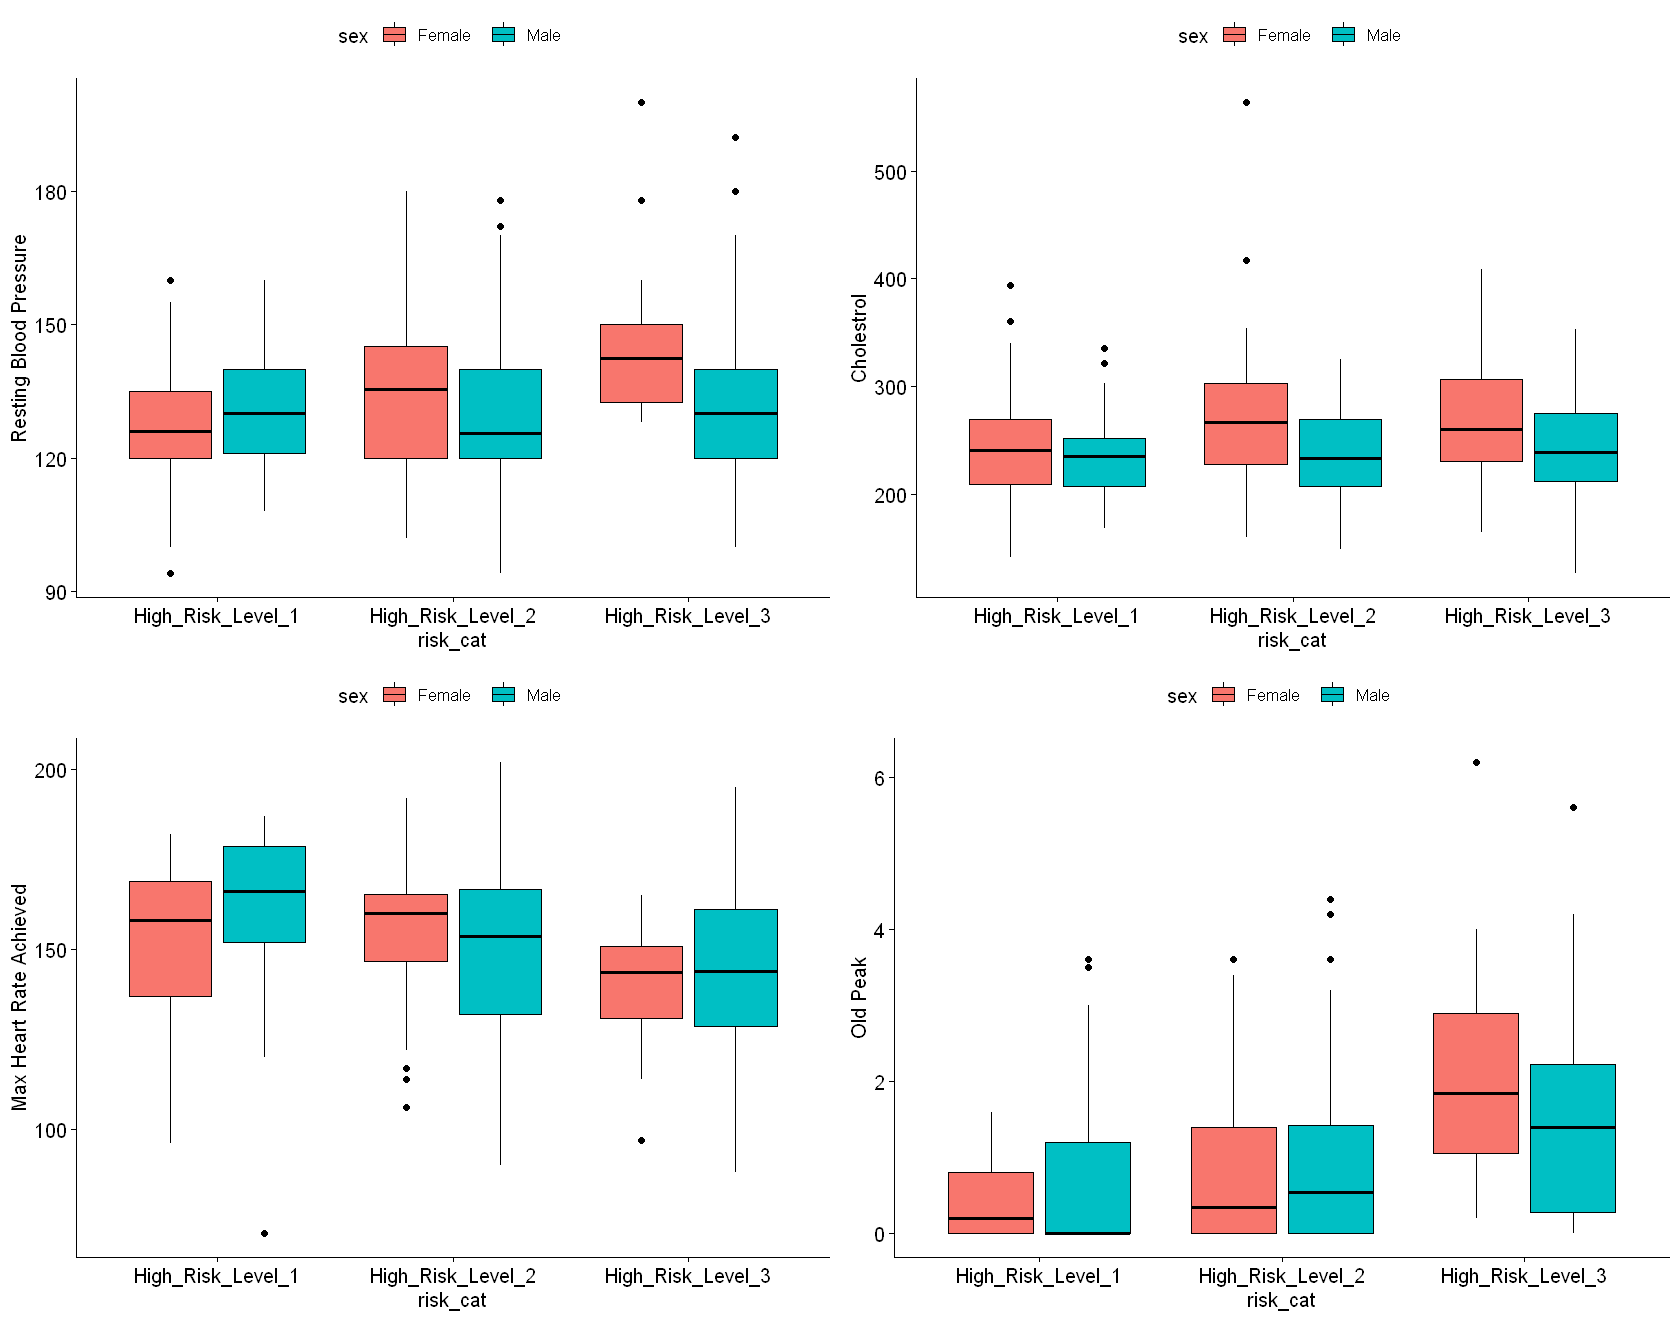

In [128]:
options(repr.plot.width=14, repr.plot.height=11)

s1=ggboxplot(dat,x='risk_cat',fill='sex',y='rest_bp')+labs(x='risk_cat',y='Resting Blood Pressure')
s2=ggboxplot(dat,x='risk_cat',fill='sex',y='cholestrol')+labs(x='risk_cat',y='Cholestrol')
s3=ggboxplot(dat,x='risk_cat',fill='sex',y='max_heart_rate')+labs(x='risk_cat',y='Max Heart Rate Achieved')
s4=ggboxplot(dat,x='risk_cat',fill='sex',y='oldpeak')+labs(x='risk_cat',y='Old Peak')

grid.arrange(s1,s2,s3,s4,ncol=2)